In [20]:
import ee
import pandas as pd

# Initialize the Earth Engine library
ee.Initialize(project='pranavkoka123')

geometry = ee.Geometry.Rectangle([78.97, 30.70, 79.20, 30.79])

# Function to calculate NDSI and apply confidence bit extraction
def calculate_ndsi_and_confidence(image):
    # NDSI = (Green - SWIR) / (Green + SWIR)
    green = image.select('B3')  # Green band
    swir = image.select('B6')  # SWIR band
    ndsi = green.subtract(swir).divide(green.add(swir)).rename('NDSI')

    # Extract snow/ice confidence (Bit 5) and cloud confidence (Bit 3)
    qa_pixel = image.select('QA_PIXEL')
    snow_confidence = qa_pixel.rightShift(5).bitwiseAnd(1).rename('Snow_Confidence')  # Bit 5
    cloud_confidence = qa_pixel.rightShift(3).bitwiseAnd(1).rename('Cloud_Confidence')  # Bit 3

    return image.addBands([ndsi, snow_confidence, cloud_confidence])

# Function to calculate the number of pixels for each snow/cloud combination
def calculate_pixel_counts(image):
    # Create masks for each S/C combination
    s0c0 = image.select('Snow_Confidence').eq(0).And(image.select('Cloud_Confidence').eq(0))
    s1c0 = image.select('Snow_Confidence').eq(1).And(image.select('Cloud_Confidence').eq(0))
    s0c1 = image.select('Snow_Confidence').eq(0).And(image.select('Cloud_Confidence').eq(1))
    s1c1 = image.select('Snow_Confidence').eq(1).And(image.select('Cloud_Confidence').eq(1))

    # Count the pixels for each combination, retrieve actual values using getInfo()
    counts = {
        's0c0': int(s0c0.reduceRegion(ee.Reducer.sum(), geometry, scale=30).get('Snow_Confidence').getInfo() or 0),
        's1c0': int(s1c0.reduceRegion(ee.Reducer.sum(), geometry, scale=30).get('Snow_Confidence').getInfo() or 0),
        's0c1': int(s0c1.reduceRegion(ee.Reducer.sum(), geometry, scale=30).get('Snow_Confidence').getInfo() or 0),
        's1c1': int(s1c1.reduceRegion(ee.Reducer.sum(), geometry, scale=30).get('Snow_Confidence').getInfo() or 0)
    }

    return counts

# Function to process images for each month of each year
def process_monthly_data(year, month):
    # Filter the image collection for the specific month
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    
    image = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
                .filterDate(start_date, end_date) \
                .filterBounds(geometry) \
                .first()
    
    # Calculate NDSI and extract confidence bits
    image_ndsi_conf = calculate_ndsi_and_confidence(image)
    
    # Get pixel counts for each S/C combination
    pixel_counts = calculate_pixel_counts(image_ndsi_conf)
    
    # Add the year and month to the result
    return {
        'year': year,
        'month': month,
        's0c0': pixel_counts['s0c0'],
        's1c0': pixel_counts['s1c0'],
        's0c1': pixel_counts['s0c1'],
        's1c1': pixel_counts['s1c1']
    }

# Loop over the years and months to generate the dataframe
results = []
for year in range(2013, 2024):
    if year == 2013:
        for month in range(4,13):
            result = process_monthly_data(year, month)
            results.append(result)
    else:    
        for month in range(1, 13):
            result = process_monthly_data(year, month)
            results.append(result)

# Convert the results to a DataFrame
df = pd.DataFrame(results)

# Display the DataFrame
print(df)


     year  month    s0c0   s1c0    s0c1  s1c1
0    2013      4   50597  36094  157484     0
1    2013      5   51440  71532  120772     0
2    2013      6   35263  42887  166026     0
3    2013      7   44537  58378  141261     0
4    2013      8   14118   9153  220904     0
..    ...    ...     ...    ...     ...   ...
124  2023      8   49624  37174  157377     0
125  2023      9   82249    359  156412     0
126  2023     10  172963  29234   41979     0
127  2023     11   53284  44634  144278     0
128  2023     12    4484      0  239692     0

[129 rows x 6 columns]


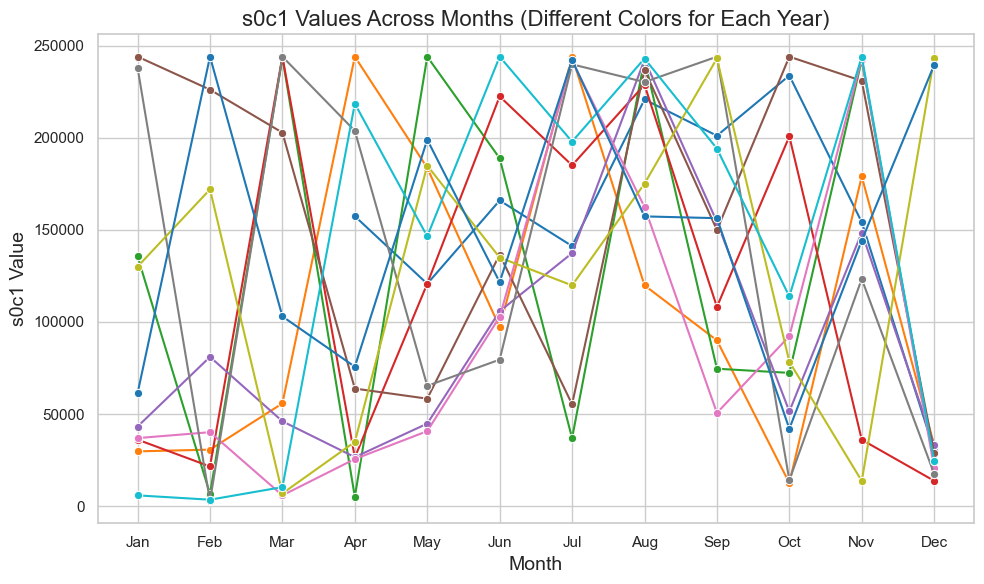

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='month', y='s0c1', hue='year', marker='o', palette='tab10', legend=False)

plt.title('s0c1 Values Across Months (Different Colors for Each Year)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('s0c1 Value', fontsize=14)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()


In [22]:
monthly_mean_s0c1 = df.groupby('month')['s0c1'].mean()
print(monthly_mean_s0c1)
monthly_median_s0c1 = df.groupby('month')['s0c1'].median()
print(monthly_median_s0c1)


month
1      96104.800000
2      82853.000000
3     116281.400000
4      98366.818182
5     128110.272727
6     145483.545455
7     167488.818182
8     205494.636364
9     151547.181818
10    105079.909091
11    159985.727273
12     64484.727273
Name: s0c1, dtype: float64
month
1      52255.0
2      35390.0
3      79400.0
4      63830.0
5     120811.0
6     135032.0
7     185119.0
8     228895.0
9     154418.0
10     78440.0
11    154236.0
12     28985.0
Name: s0c1, dtype: float64


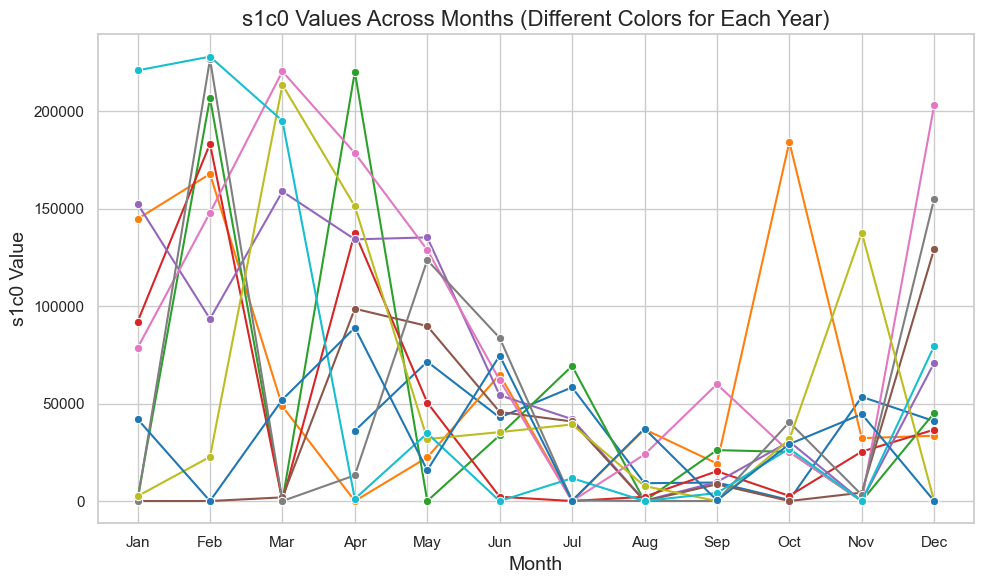

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='month', y='s1c0', hue='year', marker='o', palette='tab10', legend=False)

plt.title('s1c0 Values Across Months (Different Colors for Each Year)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('s1c0 Value', fontsize=14)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

In [24]:
monthly_mean_s1c0 = df.groupby('month')['s1c0'].mean()
print(monthly_mean_s1c0)
monthly_median_s1c0 = df.groupby('month')['s1c0'].median()
print(monthly_median_s1c0)


month
1      73491.200000
2     127746.800000
3      89094.200000
4      96411.454545
5      64059.181818
6      45423.363636
7      23829.454545
8      10646.000000
9      13910.818182
10     36070.636364
11     27374.363636
12     72245.272727
Name: s1c0, dtype: float64
month
1      60326.5
2     157988.0
3      50329.5
4      98736.0
5      50559.0
6      45738.0
7      11734.0
8       2180.0
9       9504.0
10     26899.0
11      4294.0
12     45218.0
Name: s1c0, dtype: float64


In [25]:
def calculate_ndsi_percentage(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    
    image_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
                        .filterDate(start_date, end_date) \
                        .filterBounds(geometry)

    # Calculate NDSI for each image in the collection
    images = image_collection.toList(image_collection.size())
    ndsi_values = []
    
    for i in range(images.size().getInfo()):
        image = ee.Image(images.get(i))
        image_ndsi_conf = calculate_ndsi_and_confidence(image)
        ndsi = image_ndsi_conf.select('NDSI')
        
        # Count pixels with NDSI > 0.6
        ndsi_mask = ndsi.gt(0.6)
        ndsi_count = ndsi_mask.reduceRegion(ee.Reducer.sum(), geometry, scale=30).get('NDSI').getInfo() or 0
        
        # Total pixels in the image
        total_pixels = image.select('B3').reduceRegion(ee.Reducer.count(), geometry, scale=30).get('B3').getInfo() or 1
        
        # Calculate percentage
        percentage = (ndsi_count / total_pixels) * 100 if total_pixels > 0 else 0
        ndsi_values.append(percentage)

    # Calculate average percentage for the month
    average_percentage = sum(ndsi_values) / len(ndsi_values) if ndsi_values else 0
    
    return {
        'year': year,
        'month': month,
        'ndsi_percentage': average_percentage
    }

ndsi_results = []
for year in range(2013, 2024):
    if year == 2013:
        for month in [4,12]:
            result = calculate_ndsi_percentage(year, month)
            ndsi_results.append(result)
    else:
        for month in [1, 2, 3, 4, 12]: 
            result = calculate_ndsi_percentage(year, month)
            ndsi_results.append(result)

ndsi_df = pd.DataFrame(ndsi_results)

print(ndsi_df)

    year  month  ndsi_percentage
0   2013      4        61.101966
1   2013     12        53.339418
2   2014      1        88.551039
3   2014      2        91.322983
4   2014      3        94.626546
5   2014      4        74.128459
6   2014     12        57.986915
7   2015      1        62.932239
8   2015      2        93.073553
9   2015      3        49.195886
10  2015      4        84.644388
11  2015     12        67.045696
12  2016      1        44.933063
13  2016      2        82.717656
14  2016      3        62.104101
15  2016      4        67.133255
16  2016     12        18.878517
17  2017      1        32.030745
18  2017      2        78.908631
19  2017      3        92.843501
20  2017      4        24.145589
21  2017     12        58.575889
22  2018      1        63.109954
23  2018      2        74.552015
24  2018      3        86.368379
25  2018      4        58.117296
26  2018     12        76.330232
27  2019      1        25.560944
28  2019      2        88.113974
29  2019  

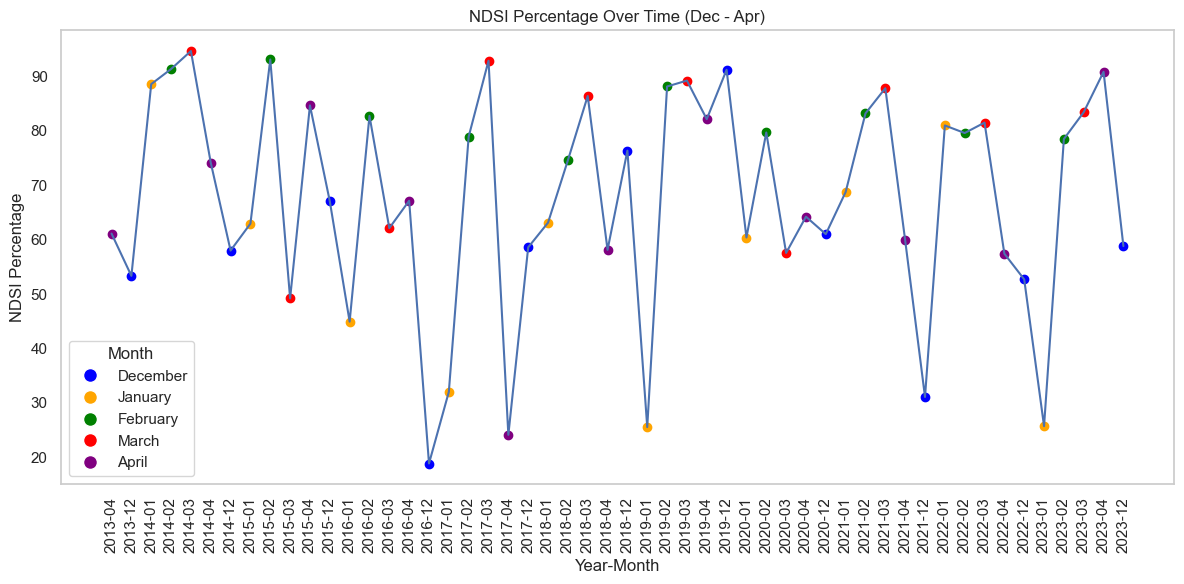

In [31]:
ndsi_df['Year-Month'] = ndsi_df['year'].astype(str) + '-' + ndsi_df['month'].astype(str).str.zfill(2)

# Define colors for each month
month_colors = {
    12: 'blue',  # December
    1: 'orange',  # January
    2: 'green',   # February
    3: 'red',     # March
    4: 'purple'   # April
}

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each data point with a specific color based on the month
for index, row in ndsi_df.iterrows():
    plt.plot(row['Year-Month'], row['ndsi_percentage'], 
             marker='o', linestyle='-', color=month_colors[row['month']])

# Adding labels and titles
plt.xticks(rotation=90)
plt.title('NDSI Percentage Over Time (Dec - Apr)')
plt.xlabel('Year-Month')
plt.ylabel('NDSI Percentage')
plt.grid()
plt.plot(ndsi_df['Year-Month'], ndsi_df['ndsi_percentage'], linestyle='-')

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label='December', markerfacecolor='blue', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='January', markerfacecolor='orange', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='February', markerfacecolor='green', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='March', markerfacecolor='red', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='April', markerfacecolor='purple', markersize=10)]
plt.legend(handles=handles, title='Month')
plt.tight_layout()
plt.show()